In [ ]:
import imp
import helper_functions
imp.reload(helper_functions)
from helper_functions import *
# TODO this is temp code, remove later.

In [1]:
import sys, itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn, time, math
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

if '../tools' not in sys.path:
    sys.path.append('../tools')
from helper_functions import * 

import warnings
warnings.filterwarnings('ignore')

Using existing FVs from file ../generated-fv/FV10-10.mat
N = 1000
MFCC training feature ranges means [-0.0039, 0.0032] sds [0.0057, 0.0188]
Train shape (900, 10880) riffled (900, 640)
Test shape (100, 10880) riffled (100, 640)


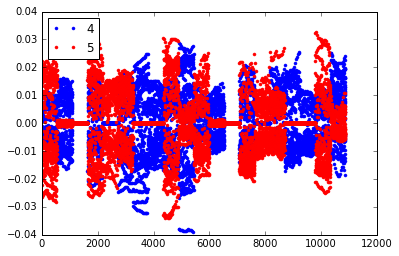

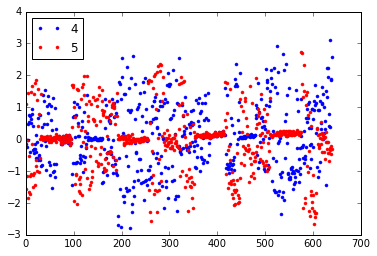

Default SVM perf orig 0.73 riff 0.73


In [2]:
num_clusters, exemplar = 10, 10
((trX, trY), (teX, teY)) = load_and_shuffle_fv(num_clusters,exemplar,0.9)

axes = plt.subplots()[1]
idx = np.where(trY != trY[0])[0][1]
#idx = np.where(trY == trY[0])[0][1] # same label
axes.plot(trX[0], c='b', marker='.', linestyle='', label=trY[0])
axes.plot(trX[idx], c='r', marker='.', linestyle='', label=trY[idx])
axes.legend(loc=2)

T = num_clusters * 2
t = (exemplar - (1 if exemplar % 2 == 0 else 0)) * 2 - 1
def whiten_train_test(train, test):
    return whiten(train), whiten(test, source=train)
trXadj, teXadj = whiten_train_test(trX, teX)
trXrff, teXrff = whiten_train_test(*(np.average(riffle(x, t, T), axis=2) for x in (trX, teX)))
print('Train shape {} riffled {}'.format(trXadj.shape, trXrff.shape))
print('Test shape {} riffled {}'.format(teXadj.shape, teXrff.shape))
axes = plt.subplots()[1]
axes.plot(trXrff[0], c='b', marker='.', linestyle='', label=trY[0])
axes.plot(trXrff[idx], c='r', marker='.', linestyle='', label=trY[idx])
axes.legend(loc=2)

plt.show()

print('Default SVM perf orig {} riff {}'.format(
        SVC(C=1.0).fit(trXadj, trY).score(teXadj, teY),
        SVC(C=1.0).fit(trXrff, trY).score(teXrff, teY)))

# no missing data

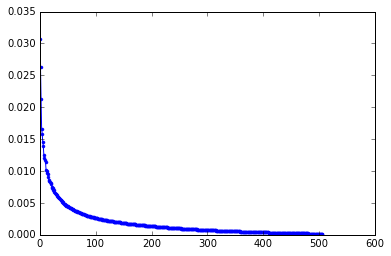

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

pca = PCA(whiten=True, n_components=0.99).fit(trXrff)
plt.plot(pca.explained_variance_ratio_, '.-')
plt.show()

In [4]:
trainX = trXrff
testX = teXrff

def logRange(lo, hi): return [10 ** i for i in range(lo, hi)]
Cs = range(20)
kernels = ['rbf']
hypers = list(itertools.product(Cs, kernels))

def print_svc(C, k): return 'C={:03f} kernel={}'.format(C, k)
def make_svc(C, k):
    if k == 'poly': return SVC(C=C, kernel=k, coef0=1.0, degree=5)
    else: return SVC(C=C, kernel=k)

best_acc, best_params = -np.inf, None
t = time.time()
for i, tup in enumerate(hypers):
    svm = make_svc(*tup)
    score = np.average(cross_val_score(svm, trainX, trY, cv=8, n_jobs=-1, pre_dispatch='2*n_jobs'))
    if score > best_acc:
        best_acc = score
        best_params = tup
    print('\r{} best acc {:03f} param {}'.format(
            completion_bar(i + 1, len(hypers), width=10), best_acc,
            print_svc(*best_params)), end='')
    sys.stdout.flush()
t = time.time() - t

svm = make_svc(*best_params)
print('\nDone with CV for {}-size hyper grid in {:03f}s'.format(
        len(hypers), t))
print('Accuracies: cv {} for {}'.format(best_acc, print_svc(*best_params)))
svm.fit(trainX, trY)
print('  re-trained test {}'.format(svm.score(testX, teY)))
# (4, 5) (cv is 0.667) .76
# (6, 6) .76

SyntaxError: invalid or missing encoding declaration for '/usr/local/lib/python3.4/dist-packages/sklearn/svm/libsvm.cpython-34m.so' (<string>)

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.ocean):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(confusion_matrix(teY, svm.predict(teXadj)))

Below is a bunch of random classifiers also attempted

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# ovo multi-classification, rbf
if sklearn.__version__ >= '0.18':
    print('warning, not ovo comparison')
svm = SVC(C=1.0)
svm.fit(trXadj, trY)
print('svm Orig accuracies: train {} test {}'.format(svm.score(trXadj, trY), svm.score(teXadj, teY)))
svm.fit(trXrff, trY)
print('svm Red accuracies: train {} test {}'.format(svm.score(trXrff, trY), svm.score(teXrff, teY)))

from sklearn.linear_model import LogisticRegressionCV
reg = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', max_iter=5000, n_jobs=8, cv=8)
reg.fit(trXadj, trY)
print('softmax Orig accuracies: train {} test {}'.format(reg.score(trXadj, trY), reg.score(teXadj, teY)))
reg.fit(trXrff, trY)
print('softmax Orig accuracies: train {} test {}'.format(reg.score(trXrff, trY), reg.score(teXrff, teY)))

In [ ]:
Ngnb = SVC(probability=True)
stumps = AdaBoostClassifier(n_estimators=30, base_estimator=gnb)
stumps.fit(trXadj, trY)
print('Orig accuracies: train {} test {}'.format(stumps.score(trXadj, trY), stumps.score(teXadj, teY)))
stumps.fit(trXred, trY)
print('Red accuracies: train {} test {}'.format(stumps.score(trXred, trY), stumps.score(teXred, teY)))

In [ ]:
v = trXred[0]
def sqmat(x):
    tx = x.reshape((1, len(x)))
    xt = x.reshape((len(x), 1))
    return np.dot(xt, tx).reshape(len(x) * len(x))
sq = np.array([sqmat(x) for x in trXred])
sqt = np.array([sqmat(x) for x in teXred])
print(sq.shape, sqt.shape)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(sq, trY)
gnb.score(sqt, teY)
svm.fit(sq, trY)
print('Accuracies: train {} test {}'.format(svm.score(sq, trY), svm.score(sqt, teY)))

In [ ]:
# Stanford mSVM http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
# This requires a new convex program formulation, unsupported within-python.

In [ ]:
class DummyPredictor:
    def __init__(self, res):
        self._res = res
    def predict(self, X):
        Y = np.empty([len(X), 1])
        Y.fill(self._res)
        return Y
        
def find_best(subsets, X, origY, C):
    best_accuracy, best_classifier, best_set = -np.inf, None, None
    val = int(0.8 * len(X))
    for subset in subsets:
        Y = np.array([y in subset for y in origY])
        svm = SVC(C=C).fit(X[:val], Y[:val])
        acc = svm.score(X[val:], Y[val:])
        if acc > best_accuracy:
            best_accuracy = acc
            best_classifier = svm
            best_set = subset
    return best_accuracy, best_classifier, best_set
    
def best_subset_finder(labels, C=1.0):
    assert len(labels) > 0
    if len(labels) == 1:
        return {}, DummyPredictor(next(iter(labels))), {}
    if len(labels) == 2:
        return {}, SVC(C=C).fit(trXadj, trY), {}
    
    subsets = []
    for i in range(1, len(labels) // 2 + 1):
        for subset in itertools.combinations(labels, i):
            subsets.append(subset)
    p = np.random.permutation(len(trXadj))
    pX = trXadj[p]
    pY = trY[p]
    
    nproc = 4
    print('  Launching {} parallel tasks for {} problems.'.format(nproc, len(subsets)))
    sys.stdout.flush()
    np.random.shuffle(subsets)
    
    best_parallel = Parallel(n_jobs=2, backend='threading') \
        (delayed(find_best)(i, pX, pY, C) for i in chunks(subsets, max(len(subsets) // nproc, 1)))
    best_accuracy, best_set, best_classifier = -np.inf, None, None
    for job_best_acc, job_best_classifier, job_best_set in best_parallel:
         if job_best_acc > best_accuracy:
             best_accuracy = job_best_acc
             best_classifier = job_best_classifier
             best_set = set(job_best_set)
         
    other = labels - best_set
    print('  Split on 0/1 for {} vs {}, validation acc {}'.format(
        best_set, other, best_accuracy))
    sys.stdout.flush()
    assert best_classifier
    return best_set, best_classifier, other

class DTree(object):
    def __init__(self, classifier, lset, rset):
        self.lset = lset
        self.rset = rset
        self.left = None
        self.right = None
        self.classifier = classifier

def binary_dtree(labels, C=10.0, debug_print_level=None):
    dbp = debug_print_level
    if dbp: print('Level {}'.format(dbp))
    left, svm, right = best_subset_finder(labels)
    if not left: assert not right
    x = DTree(svm, left, right)
    if not left: return x
    x.left = binary_dtree(left, C=(C * len(left) / len(labels)),
                          debug_print_level=(dbp + '0' if dbp else None))
    x.right = binary_dtree(right, C=(C * len(right) / len(labels)),
                           debug_print_level=(dbp + '1' if dbp else None))
    return x

In [ ]:
bdt = binary_dtree(set(trY), C=10.0, debug_print_level='r')

In [ ]:
#What if we retrain on the whole training dataset?
def dtree_predict(dt, x):
    y = dt.classifier.predict([x])[0]
    if not dt.left: return y
    subtree = dt.left if y else dt.right
    return dtree_predict(subtree, x)

def vec_dtree_predict(dt, X):
    return np.array([dtree_predict(dt, x) for x in X])

np.sum(vec_dtree_predict(bdt, teXadj) == teY) / len(teY)